# Importing processed data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/dataset/Pascal_VOC/cache/

/content/drive/MyDrive/dataset/Pascal_VOC/cache


# Importing required Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 # For image resizing.

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import layers
from tensorflow.keras.applications.vgg16 import VGG16

There are 20 labels in this problem

In [4]:
labels = np.array(['person', 'bird', 'cat', 'cow', 'dog', 'horse',
              'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car',
              'motorbike', 'train', 'bottle', 'chair', 'dining table',
              'potted plant', 'sofa', 'tv/monitor'])

Loading the images

In [5]:
abstract_images = np.load('abstract_images.npy')
abstract_targets = np.load('abstract_targets.npy')

pascal_images = np.load('pascal_images.npy', allow_pickle=True)
pascal_targets = np.load('pascal_targets.npy')

A sample from Abstract50s dataset.

array(['person', 'cat'], dtype='<U12')

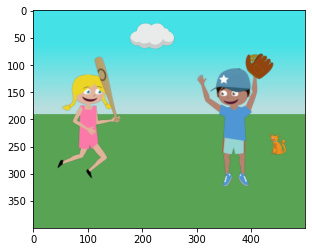

In [6]:
index = 0
plt.imshow(abstract_images[index])
labels[abstract_targets[index] == 1]

A sample from Pascal50s dataset

array(['dog'], dtype='<U12')

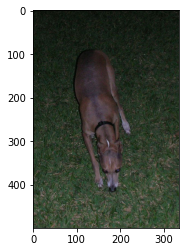

In [7]:
index = 11
plt.imshow(pascal_images[index])
labels[pascal_targets[index] == 1]

Removing alpha channel

In [8]:
abstract_images = abstract_images[:, :, :, :3]

Resizing

In [9]:
def resizing(images):
  temp = []
  for image in images:
    resized = cv2.resize(image, (250, 200), interpolation=cv2.INTER_AREA)
    temp.append(resized)

  images = np.array(temp)
  return images

In [10]:
abstract_images = resizing(abstract_images)

In [11]:
pascal_images = resizing(pascal_images)

Normalization. 

*Note: Abstract50s is normalized by default*

In [12]:
pascal_images = pascal_images / 255

Combining the two datasets

In [13]:
images = np.concatenate((pascal_images, abstract_images), axis=0)

In [14]:
targets = np.concatenate((pascal_targets, abstract_targets), axis=0)

Since our data is extremely imbalanced so we will keep track of the class weights to train the model better.

In [15]:
class_weights = np.sum(targets, axis=0)
class_weights = dict(zip(range(20), class_weights))

We split or dataset into train and test

*Note: the dataset is also shuffled in this process*

In [17]:
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.15)

# Model

In [18]:
def get_model():
  model = keras.models.Sequential()
  model.add(layers.Conv2D(input_shape=(images.shape[1],images.shape[2],3),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=128, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2), name='MP_2'))

  model.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu", name='last_conv'))
  model.add(layers.BatchNormalization())
  headModel = model.output
  headModel = layers.Flatten()(headModel)
  headModel = layers.Dropout(rate=0.1)(headModel)

  headModel = layers.Dense(64, activation='relu')(headModel)
  headModel = layers.Dense(64, activation='relu')(headModel)
  headModel = layers.Dense(len(labels), activation='sigmoid')(headModel)
  model = keras.models.Model(inputs=model.input, outputs=headModel)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [19]:
def get_vgg():
  base_model = VGG16(input_shape = (images.shape[1],images.shape[2], 3), include_top = False, weights = 'imagenet')
  for layer in base_model.layers:
    layer.trainable = False
  x = layers.Flatten()(base_model.output)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(len(labels), activation='sigmoid')(x)

  model = keras.models.Model(base_model.input, x)

  model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['acc'])
  return model

In [20]:
# model = get_model()
model = get_vgg()

58892288/58889256 [==============================] - 0s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 62, 128)       0     

We will use the follow two callbacks
- Early Stopping - To prevent overfitting
- Model Checkpoint - To save our model's training progress.

In [22]:
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
cp = keras.callbacks.ModelCheckpoint('model1.h5', save_best_only=True)

### The training begins !

Note: the class_weights arugment is passed to acknowlegde the imbalanced dataset

In [23]:
model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), batch_size=32, callbacks=[es, cp], class_weight=class_weights)

Epoch 1/25
40/40 [==============================] - 51s 310ms/step - loss: 292.8799 - acc: 0.5925 - val_loss: 0.2258 - val_acc: 0.7200
Epoch 2/25
40/40 [==============================] - 6s 148ms/step - loss: 118.2095 - acc: 0.6682 - val_loss: 0.2092 - val_acc: 0.7156
Epoch 3/25
40/40 [==============================] - 6s 149ms/step - loss: 81.0756 - acc: 0.6813 - val_loss: 0.2013 - val_acc: 0.6978
Epoch 4/25
40/40 [==============================] - 6s 149ms/step - loss: 61.2795 - acc: 0.6196 - val_loss: 0.2187 - val_acc: 0.6844
Epoch 5/25
40/40 [==============================] - 6s 150ms/step - loss: 45.6060 - acc: 0.6249 - val_loss: 0.2106 - val_acc: 0.6800
Epoch 6/25
40/40 [==============================] - 6s 149ms/step - loss: 29.9109 - acc: 0.5960 - val_loss: 0.2322 - val_acc: 0.7067
Epoch 7/25
40/40 [==============================] - 6s 150ms/step - loss: 21.6214 - acc: 0.5741 - val_loss: 0.2336 - val_acc: 0.7111
Epoch 8/25
40/40 [==============================] - 6s 151ms/step 

# Evaluation

In [24]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 112ms/step - loss: 0.2013 - acc: 0.6978


[0.20127879083156586, 0.6977777481079102]

In [25]:
preds = (model.predict(images) > 0.5) * 1

## F1 score

This is a better metrics of measurement as the dataset is imbalanced

In [26]:
print(classification_report(preds, targets))

              precision    recall  f1-score   support

           0       1.00      0.69      0.82      1497
           1       0.40      1.00      0.57        30
           2       0.08      1.00      0.14        10
           3       0.24      1.00      0.38        14
           4       0.28      0.97      0.44        60
           5       0.37      0.96      0.53        23
           6       0.12      1.00      0.22         7
           7       0.44      0.98      0.61        50
           8       0.53      0.97      0.69        34
           9       0.53      0.84      0.65        37
          10       0.71      0.68      0.70        66
          11       0.16      1.00      0.27        21
          12       0.82      0.92      0.87        97
          13       0.26      1.00      0.41        17
          14       0.51      0.95      0.67        37
          15       0.06      1.00      0.12         8
          16       0.61      0.89      0.72       167
          17       0.03    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
